# Libraries

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten, Input,MaxPool2D,Dropout,AveragePooling2D,concatenate,BatchNormalization,Activation, Add,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


# Preprocessing

In [10]:
data_directory = '/kaggle/input/teeth-dataset/Teeth_Dataset/'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Training",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Validation",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Testing",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

class_names = train_dataset.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))
print("Number of Batches:", len(train_dataset))

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class Names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of Classes: 7
Number of Batches: 97


# Inception

In [8]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output

def build_inception_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D((7, 7), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [15]:
with strategy.scope():
    input_shape = (256, 256, 3)  
    num_classes = 7 
    model = build_inception_model(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [16]:
model.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100


2024-08-21 13:28:32.294812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_786/cond/StatefulPartitionedCall/functional_2_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.1743 - loss: 2.1738 - val_accuracy: 0.1751 - val_loss: 2.0827
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.1914 - loss: 1.9331 - val_accuracy: 0.2198 - val_loss: 1.8652
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.2127 - loss: 1.8813 - val_accuracy: 0.2607 - val_loss: 1.8427
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.2281 - loss: 1.8436 - val_accuracy: 0.1848 - val_loss: 2.1424
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.2395 - loss: 1.8168 - val_accuracy: 0.1634 - val_loss: 2.0494
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.2434 - loss: 1.7851 - val_accuracy: 0.2821 - val_loss: 1.7277
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.2407 - loss: 1.7997 - val_accuracy: 0.2724 - val_loss: 1.7576
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.2613 - loss: 1.7763 - val_accuracy

In [17]:
metrics = pd.DataFrame(model.history.history)

<Axes: >

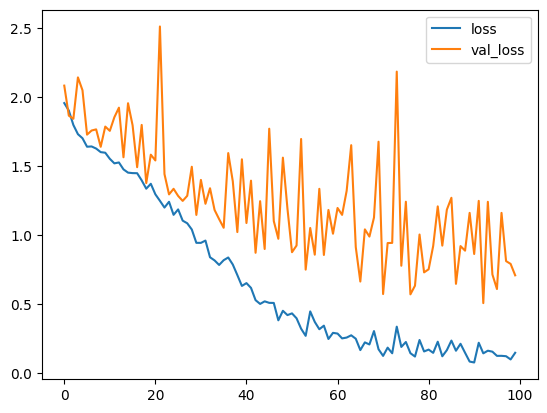

In [18]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

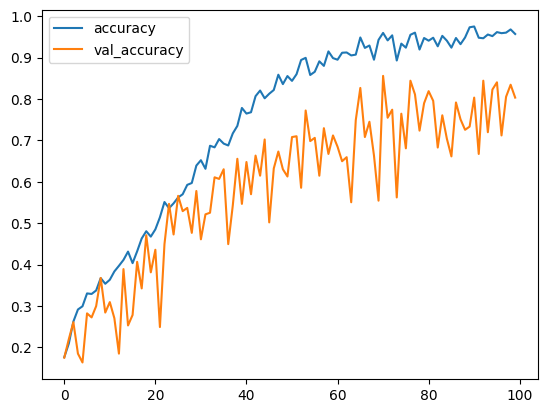

In [19]:
metrics[['accuracy', 'val_accuracy']].plot()

In [20]:
evalu = model
scores = evalu.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8385 - loss: 0.6416


# Res-Net

In [25]:
def resnet_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, filters=64, conv_shortcut=False)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=128, stride=2)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=256, stride=2)
    x = resnet_block(x, filters=256)
    x = resnet_block(x, filters=512, stride=2)
    x = resnet_block(x, filters=512)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 3) 
num_classes = 7

In [27]:
with strategy.scope():
    model = build_resnet(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [28]:
model.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 227ms/step - accuracy: 0.2345 - loss: 2.2189 - val_accuracy: 0.1576 - val_loss: 13.5876
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.3156 - loss: 1.7407 - val_accuracy: 0.1342 - val_loss: 32.8746
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.3586 - loss: 1.6586 - val_accuracy: 0.1226 - val_loss: 6.4384
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.3897 - loss: 1.5826 - val_accuracy: 0.1401 - val_loss: 4.5976
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.4286 - loss: 1.5080 - val_accuracy: 0.1479 - val_loss: 3.4186
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.4567 - loss: 1.4399 - val_accuracy: 0.1770 - val_loss: 5.2754
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.4781 - loss: 1.3581 - val_accuracy: 0.1304 - val_loss: 9.1336
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.4922 - loss: 1.3319 

In [29]:
metrics = pd.DataFrame(model.history.history)

<Axes: >

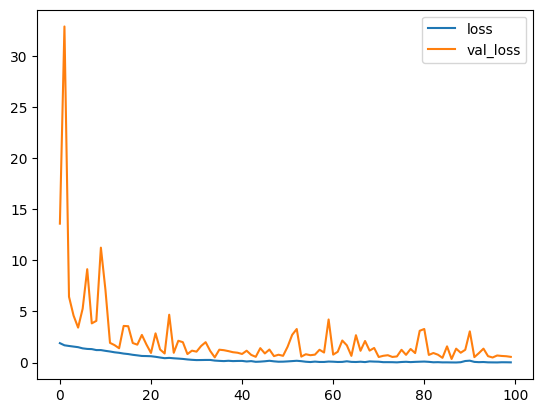

In [30]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

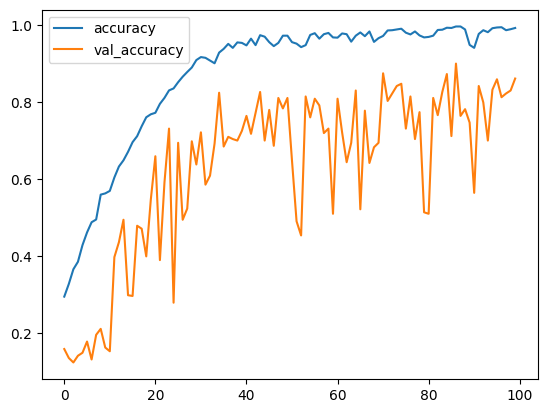

In [31]:
metrics[['accuracy', 'val_accuracy']].plot()

In [32]:
evalu = model
scores = evalu.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8110 - loss: 0.7848
